# Modelling probability of admission to specialty, if admitted

This notebook demonstrates the second stage of prediction, to generate a probability of admission to a specialty for each patient in the ED if they are admitted. 

Here consult sequences provide the input to prediction, and the model is trained only on visitsby adult patients that ended in admission. Patients less than 18 at the time of arrival to the ED are assumed to be admitted to paediatric wards. This assumption could be relaxed by changing the training data to include children, and changing how the inference stage is done. 

This approach assumes that, if admitted, a patient's probability of admission to any particular specialty is independent of their probability of admission to hospital. 

## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [3]:
from pathlib import Path
import sys
import json
import pandas as pd

PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'Repos'

sys.path.append(str(USER_ROOT / 'patientflow' / 'src' / 'patientflow'))
sys.path.append(str(USER_ROOT / 'patientflow' / 'functions'))




## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [4]:
uclh = False

if uclh:
    
    model_file_path = USER_ROOT / 'ed-predictor' / 'trained-models'
    data_path = USER_ROOT / 'ed-predictor' / 'data-raw'
    media_file_path = USER_ROOT / 'ed-predictor' / 'media'
    media_file_path.mkdir(parents=True, exist_ok=True)

else:
    
    model_file_path = USER_ROOT / 'patientflow' / 'trained-models'
    data_path = USER_ROOT / 'patientflow' / 'data-raw'
    media_file_path = USER_ROOT / 'patientflow' / 'notebooks' / 'img'

In [5]:
from load_config import load_config_file

if uclh:
    config_path = Path(USER_ROOT / 'patientflow' / 'config-uclh.yaml')
else:
    config_path = Path(USER_ROOT / 'patientflow' / 'config.yaml')

params = load_config_file(config_path)

prediction_times = params[0]
start_training_set, start_validation_set, start_test_set, end_test_set = params[1:5]


In [6]:
start_test_set

datetime.date(2031, 10, 1)

## Load data

In [9]:
import pandas as pd
from load_data_utils import set_file_locations
from load import data_from_csv

if uclh:
    data_path = USER_ROOT / 'ed-predictor' / 'data-raw'
    model_file_path = USER_ROOT / 'ed-predictor' / 'trained-models'
    visits_path, visits_csv_path, yta_path, yta_csv_path = set_file_locations(uclh, data_path, config_path)
else:
    visits_csv_path, yta_csv_path = set_file_locations(uclh, data_path)

visits = data_from_csv(visits_csv_path, index_column = 'snapshot_id',
                            sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                            eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])


visits['snapshot_date'] = pd.to_datetime(visits['snapshot_date']).dt.date


Select only the visits that ended in admission, and the relevant subset of columns

In [11]:
if uclh:
    bins = [-1, 18, 25, 35, 45, 55, 65, 75, 102]
    labels = ['0-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75-102']
    visits['age_group'] = pd.cut(visits['age_on_arrival'], bins=bins, labels=labels, right=True)

visits = visits[visits.is_admitted]#[['snapshot_date', 'prediction_time', 'visit_number', 'age_group', 'consultation_sequence', 'final_sequence', 'specialty', 'training_validation_test']]

Print the number of unique visits in this dataset. As noted in the previous notebooks, there are multiple rows per visit

In [12]:
print(f'Number of records in dataset used for specialty model: {str(len(visits))}')
print(f'Number of unique visits in dataset used for specialty model: {str(visits.visit_number.nunique())}')


Number of records in dataset used for specialty model: 31128
Number of unique visits in dataset used for specialty model: 22120


In [13]:
# remove children
visits = visits[~(visits.age_group == '0-17')]

In [14]:
print(f"Dropping {str(len(visits[visits.specialty.isnull()]))} rows without a specialty")
visits = visits[~visits.specialty.isnull()]

Dropping 419 rows without a specialty


In [15]:
# also remove adults who were admitted to a paediatric specialty
print(f"Dropping {str(len(visits[visits.specialty == 'paediatric']))} adults who were admitted to a paediatric specialty")
visits = visits[~(visits.specialty == 'paediatric')]

Dropping 14 adults who were admitted to a paediatric specialty


Note that some visits that ended in admission had no consult request at the time they were sampled, as we can see below

In [16]:
visits.head()


,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,...,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,training_validation_test,final_sequence,is_admitted,random_number,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
3,2030-11-01,"(22, 0)",4.0,15600.0,F,75-102,NaN,sdec,4.0,400.0,...,1.2,136.0,5.41,7.371,14.10,train,[acute],True,103694,surgical
9,2030-04-12,"(22, 0)",14.0,13380.0,M,65-74,Walk-in,sdec,8.0,76.0,...,NaN,133.0,NaN,NaN,3.52,train,[haem_onc],True,87498,haem/onc
14,2030-04-01,"(6, 0)",357.0,9762.0,M,55-64,Ambulance,sdec,5.0,76.0,...,0.5,134.0,4.98,7.490,6.05,train,"[haem_onc, acute, haem_onc]",True,16023,haem/onc
15,2030-04-01,"(9, 30)",357.0,22362.0,M,55-64,Ambulance,sdec,5.0,96.0,...,0.5,134.0,4.06,7.562,6.05,train,"[haem_onc, acute, haem_onc]",True,41090,haem/onc
16,2030-04-01,"(6, 0)",360.0,11836.0,F,75-102,Ambulance,majors,5.0,55.0,...,1.0,140.0,6.15,7.385,4.47,train,"[neuro, neuro]",True,67221,medical


In [17]:
visits[visits.consultation_sequence.apply(lambda x: x == [])]


,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,...,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,training_validation_test,final_sequence,is_admitted,random_number,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
16,2030-04-01,"(6, 0)",360.0,11836.0,F,75-102,Ambulance,majors,5.0,55.0,...,1.0,140.0,6.15,7.385,4.47,train,"[neuro, neuro]",True,67221,medical
35,2030-04-01,"(12, 0)",377.0,12307.0,F,45-54,Walk-in,majors,3.0,49.0,...,1.6,132.0,5.52,7.519,6.66,train,[surgical],True,190222,surgical
34,2030-04-01,"(9, 30)",377.0,3307.0,F,45-54,Walk-in,majors,3.0,27.0,...,1.6,NaN,5.52,7.519,6.66,train,[surgical],True,123855,surgical
43,2030-04-01,"(12, 0)",385.0,9492.0,M,45-54,Walk-in,majors,5.0,45.0,...,1.9,138.0,6.51,7.388,14.29,train,[surgical],True,66803,surgical
42,2030-04-01,"(9, 30)",385.0,492.0,M,45-54,Walk-in,rat,4.0,14.0,...,NaN,NaN,NaN,NaN,NaN,train,[surgical],True,56886,surgical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197951,2032-04-30,"(22, 0)",187836.0,7103.0,F,35-44,Ambulance,majors,3.0,13.0,...,NaN,NaN,NaN,NaN,NaN,test,[acute],True,147831,surgical
197984,2032-04-30,"(22, 0)",187873.0,3780.0,M,45-54,NaN,waiting,3.0,22.0,...,1.9,NaN,6.24,7.347,NaN,test,[acute],True,126380,medical
197989,2032-04-30,"(22, 0)",187878.0,2435.0,F,55-64,Ambulance,majors,5.0,16.0,...,2.0,NaN,6.16,7.468,NaN,test,[surgical],True,12655,surgical


To handle the fact that there are multiple snapshots per visit, load the same training set as used in the admission models (which uses one snapshot per visit) and train the model using the same snapshots. First, retrieve the original training data

In [18]:
from prepare import select_one_snapshot_per_visit

visits_single = select_one_snapshot_per_visit(visits, visit_col = 'visit_number')

print(visits.shape)
print(visits_single.shape)

(28055, 69)
(19598, 68)


Now used the retrieved data to select only those visits rows which are in visits_single. 

In [19]:
print(visits.shape)
visits_single = visits.loc[visits.index.isin(visits_single.index)].copy()
print(visits_single.shape)

(28055, 69)
(19598, 69)


As the sequence predictor requires tuples as input, we will convert the lists to tuples

In [20]:
visits_single['consultation_sequence'] = visits_single['consultation_sequence'].apply(lambda x: tuple(x) if x else ())
visits_single['final_sequence'] = visits_single['final_sequence'].apply(lambda x: tuple(x) if x else ())


In [21]:
visits_single.head()

,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,...,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,training_validation_test,final_sequence,is_admitted,random_number,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
3,2030-11-01,"(22, 0)",4.0,15600.0,F,75-102,NaN,sdec,4.0,400.0,...,1.2,136.0,5.41,7.371,14.10,train,"(acute,)",True,103694,surgical
9,2030-04-12,"(22, 0)",14.0,13380.0,M,65-74,Walk-in,sdec,8.0,76.0,...,NaN,133.0,NaN,NaN,3.52,train,"(haem_onc,)",True,87498,haem/onc
15,2030-04-01,"(9, 30)",357.0,22362.0,M,55-64,Ambulance,sdec,5.0,96.0,...,0.5,134.0,4.06,7.562,6.05,train,"(haem_onc, acute, haem_onc)",True,41090,haem/onc
16,2030-04-01,"(6, 0)",360.0,11836.0,F,75-102,Ambulance,majors,5.0,55.0,...,1.0,140.0,6.15,7.385,4.47,train,"(neuro, neuro)",True,67221,medical
18,2030-04-01,"(6, 0)",363.0,9181.0,F,65-74,Ambulance,resus,3.0,89.0,...,0.8,141.0,5.71,7.462,20.60,train,"(icu,)",True,769,medical


## Separate into training, validation and test sets

As part of preparing the data, each visit has already been allocated into one of three sets - training, vaidation and test sets. This has been done chronologically, as shown by the output below. Using a chronological approach is appropriate for tasks where the model needs to be validated on unseen, future data.


In [23]:
train_visits = visits_single.loc[visits_single.index.isin(visits[visits.training_validation_test == 'train'].index)]
valid_visits = visits_single.loc[visits_single.index.isin(visits[visits.training_validation_test == 'valid'].index)]
test_visits = visits_single.loc[visits_single.index.isin(visits[visits.training_validation_test == 'test'].index)]


assert train_visits.snapshot_date.min() == start_training_set
assert train_visits.snapshot_date.max() < start_validation_set
assert valid_visits.snapshot_date.min() == start_validation_set
assert valid_visits.snapshot_date.max() < start_test_set
assert test_visits.snapshot_date.min() == start_test_set
assert test_visits.snapshot_date.max() < end_test_set

## Train the model

Here, we load the SequencePredictor(), a function that takes a sequence as input (in this case consultation_sequence), a grouping variable (in this case final_sequence) and a outcome variable (in this case specialty), and uses a grouping variable to create a rooted directed tree. Each new consult in the sequence is a branching node of the tree. The grouping variable, final sequence, serves as the terminal nodes of the tree. The function maps the probability of each part-complete sequence of consults ending (via each final_sequence) in each specialty of admission.

In [25]:
from predictors.sequence_predictor import SequencePredictor

In [24]:
model = SequencePredictor(input_var = 'consultation_sequence',
                       grouping_var = 'final_sequence',
                       outcome_var = 'specialty')
model.fit(train_visits)



SequencePredictor(grouping_var='final_sequence',
                  input_var='consultation_sequence', outcome_var='specialty')

Passing an empty tuple to the trained model shows the probability of ending in each specialty, if a visit has had no consults yet. 

In [137]:
model.predict(tuple()) 

{'surgical': 0.2699213233810772,
 'medical': 0.6304216259834579,
 'haem/onc': 0.099657050635465}

In [78]:
model.predict(tuple(['medical'])) 

{'surgical': 0.05839416058394161,
 'medical': 0.9124087591240875,
 'haem/onc': 0.029197080291970802}

The probabilities for each consult sequence ending in a given observed specialty have been saved in the model. These can be accessed as follows: 

In [79]:
weights = model.weights
weights[tuple(['surgical'])]

{'surgical': 0.888888888888889,
 'medical': 0.10447761194029852,
 'haem/onc': 0.006633499170812605}

The intermediate mapping of consultation_sequence to final_sequence can be accessed from the trained model like this. The first row shows the probability of a null sequence (ie no consults yet) ending in any of the final_sequence options. 

In [80]:
model.input_to_grouping_probs

final_sequence,(),"(acute,)","(acute, acute)","(acute, acute, medical)","(acute, acute, medical, surgical)","(acute, acute, mental_health)","(acute, acute, palliative)","(acute, acute, surgical)","(acute, allied)","(acute, allied, acute)",...,"(surgical, surgical)","(surgical, surgical, acute)","(surgical, surgical, acute, mental_health, discharge, discharge)","(surgical, surgical, acute, surgical)","(surgical, surgical, icu)","(surgical, surgical, medical)","(surgical, surgical, obs_gyn)","(surgical, surgical, other)","(surgical, surgical, surgical)",probability_of_grouping_sequence
consultation_sequence,,,,,,,,,,,,,,,,,,,,,
(),0.009819,0.458837,0.013218,0.000755,0.000378,0.000755,0.000000,0.000378,0.005665,0.000378,...,0.007553,0.000755,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000378,0.534194
"(acute,)",0.000000,0.830409,0.005848,0.000000,0.000000,0.000000,0.000000,0.000000,0.014620,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.206980
"(acute, acute)",0.000000,0.000000,0.909091,0.045455,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.004438
"(acute, allied)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000202
"(acute, ambulatory)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(surgical, medical)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000403
"(surgical, obs_gyn)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000403
"(surgical, surgical)",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.814815,0.000000,0.037037,0.0,0.0,0.037037,0.037037,0.037037,0.037037,0.005447


In [81]:
from joblib import dump, load

MODEL__ED_SPECIALTY__NAME = 'ed_specialty'

# use this name in the path for saving the model
full_path = model_file_path / MODEL__ED_SPECIALTY__NAME 
full_path = full_path.with_suffix('.joblib')

# save the model
dump(model, full_path)

['/home/jovyan/work/patientflow/trained-models/ed_specialty.joblib']

## Do inference on the test set

In [82]:
from prepare import prepare_for_inference
model = prepare_for_inference(model_file_path, 'ed_specialty', model_only = True)

In [83]:
model.predict(None)

{'surgical': 0.2699213233810772,
 'medical': 0.6304216259834579,
 'haem/onc': 0.099657050635465}

In [165]:
def prepare_snapshots_dict(df, start_dt=None, end_dt=None):
    """
    Prepares a dictionary mapping horizon dates to their corresponding snapshot indices.

    Args:
    df (pd.DataFrame): DataFrame containing at least a 'snapshot_date' column which represents the dates.
    start_dt (datetime.date): Start date (optional)
    end_dt (datetime.date): End date (optional)

    Returns:
    dict: A dictionary where keys are dates and values are arrays of indices corresponding to each date's snapshots.
    A array can be empty if there are no snapshots associated with a date

    """
    # Ensure 'snapshot_date' is in the DataFrame
    if "snapshot_date" not in df.columns:
        raise ValueError("DataFrame must include a 'snapshot_date' column")

    # Group the DataFrame by 'snapshot_date' and collect the indices for each group
    snapshots_dict = {
        date: group.index.tolist() for date, group in df.groupby("snapshot_date")
    }

    # If start_dt and end_dt are specified, add any missing keys from prediction_dates
    if start_dt:

        prediction_dates = pd.date_range(start=start_dt, end=end_dt, freq='D').date.tolist()[:-1]
        print(len(prediction_dates))
        for dt in prediction_dates:
            if dt not in snapshots_dict:
                print(dt)
                snapshots_dict[dt] = []

    return snapshots_dict

snapshots_dict = prepare_snapshots_dict(visits.loc[non_zero_indices], start_dt=start_test_set, end_dt=end_test_set)
len(snapshots_dict.keys())

92
2031-10-01
2031-10-03
2031-10-04
2031-10-05
2031-10-08
2031-10-09
2031-10-10
2031-10-11
2031-10-13
2031-10-14
2031-10-15
2031-10-17
2031-10-18
2031-10-19
2031-10-21
2031-10-22
2031-10-23
2031-10-24
2031-10-25
2031-10-26
2031-10-27
2031-10-29
2031-10-31
2031-11-01
2031-11-02
2031-11-03
2031-11-04
2031-11-05
2031-11-06
2031-11-09
2031-11-10
2031-11-11
2031-11-12
2031-11-14
2031-11-15
2031-11-16
2031-11-18
2031-11-20
2031-11-21
2031-11-22
2031-11-23
2031-11-24
2031-11-26
2031-11-27
2031-11-28
2031-11-30
2031-12-01
2031-12-02
2031-12-03
2031-12-05
2031-12-06
2031-12-07
2031-12-10
2031-12-11
2031-12-12
2031-12-15
2031-12-17
2031-12-19
2031-12-22
2031-12-24
2031-12-25
2031-12-26
2031-12-27
2031-12-29
2031-12-31


92

In [139]:
visits

,snapshot_date,visit_number,age_group,consultation_sequence,final_sequence,specialty,training_validation_test,random_number
snapshot_id,,,,,,,,
19,2031-03-01,82062.0,45-54,[],"[surgical, surgical]",surgical,train,0.374540
20,2031-03-01,82062.0,45-54,[surgical],"[surgical, surgical]",surgical,train,0.950714
58,2031-03-01,82270.0,35-44,[surgical],[surgical],surgical,train,0.731994
59,2031-03-01,82270.0,35-44,[surgical],[surgical],surgical,train,0.598658
77,2031-03-01,82281.0,65-74,[],[acute],medical,train,0.156019
...,...,...,...,...,...,...,...,...
79752,2031-12-31,155249.0,55-64,[acute],[acute],medical,test,0.702966
79756,2031-12-31,155255.0,45-54,[acute],[acute],medical,test,0.182663
79757,2031-12-31,155257.0,65-74,[acute],[acute],medical,test,0.609869


In [166]:


from prepare import prepare_for_inference, get_specialty_probs, prepare_snapshots_dict
from load import get_model_name
from aggregate import get_prob_dist
from ed_specialty_paediatric_functions import create_special_category_objects, validate_special_category_objects

special_params = create_special_category_objects(uclh)
validate_special_category_objects(special_params)
special_category_func = special_params["special_category_func"]
special_category_dict = special_params["special_category_dict"]
special_func_map = special_params["special_func_map"]


prob_dist_dict_all = {}

for _prediction_time in prediction_times[0:1]:

    print("\nProcessing :" + str(_prediction_time))
    
    # get model name for this time of day
    MODEL__ED_ADMISSIONS__NAME = get_model_name('ed_admission', _prediction_time)
    
    # initialise a dictionary to save specialty predictions
    prob_dist_dict_all[MODEL__ED_ADMISSIONS__NAME] = {}

    df =  visits[(visits.training_validation_test == 'test') &
                (visits.prediction_time == _prediction_time)]

    # prepare data and model
    X_test, y_test, admissions_model = prepare_for_inference(
        model_file_path=model_file_path,
        model_name="ed_admission",
        prediction_time=_prediction_time, 
        single_snapshot_per_visit = False,
        model_only=False,
        df=df
    )
    
    # set consultation sequence to tuple
    X_test['consultation_sequence'] = X_test['consultation_sequence'].apply(lambda x: () if not x else tuple(x))
    
    # this function will return a dictionary of probabilities for each 
    X_test['specialty_prob'] = get_specialty_probs(model_file_path, X_test, special_category_func, special_category_dict)
    
    for spec_ in ['medical', 'surgical', 'haem/onc', 'paediatric']:
        print("\nProcessing probability of admission to:" + spec_ )

        func = special_func_map.get(spec_, special_func_map["default"])
        non_zero_indices = X_test[
            X_test.apply(func, axis=1)
        ].index

        filtered_prob_admission_after_ed = X_test.loc[non_zero_indices]

        prob_admission_to_specialty = X_test["specialty_prob"].apply(
            lambda x: x[spec_]
        )
        filtered_prob_admission_to_specialty = prob_admission_to_specialty.loc[
            non_zero_indices
        ]       

        snapshots_dict = prepare_snapshots_dict(df.loc[non_zero_indices], start_dt=start_test_set, end_dt=end_test_set)


        print(len(snapshots_dict.keys()))

        
        # get probability distribution for this time of day
        prob_dist_dict_all[MODEL__ED_ADMISSIONS__NAME][spec_] = get_prob_dist(
            snapshots_dict, X_test, y_test, admissions_model, weights=filtered_prob_admission_to_specialty
        )
        
    # # use model name in the path for saving the prob dist
    # full_path = prob_dist_file_path / str(MODEL__ED_ADMISSIONS__NAME + '_with_spec') 
    # full_path = full_path.with_suffix('.pickle')
        
    # with open(full_path, 'wb') as f:  # Note the 'wb' mode for binary writing
    #     pickle.dump(prob_dist_dict_all[MODEL__ED_ADMISSIONS__NAME], f)
    
            


Processing :(6, 0)

Processing probability of admission to:medical
92
Calculating probability distributions for 92 snapshot dates
This may take a minute or more
Processed 10 snapshot dates
Processed 20 snapshot dates
Processed 30 snapshot dates
Processed 40 snapshot dates
Processed 50 snapshot dates
Processed 60 snapshot dates
Processed 70 snapshot dates
Processed 80 snapshot dates
Processed 90 snapshot dates
Processed 92 snapshot dates

Processing probability of admission to:surgical
92
Calculating probability distributions for 92 snapshot dates
This may take a minute or more
Processed 10 snapshot dates
Processed 20 snapshot dates
Processed 30 snapshot dates
Processed 40 snapshot dates
Processed 50 snapshot dates
Processed 60 snapshot dates
Processed 70 snapshot dates
Processed 80 snapshot dates
Processed 90 snapshot dates
Processed 92 snapshot dates

Processing probability of admission to:haem/onc
92
Calculating probability distributions for 92 snapshot dates
This may take a minute 

In [103]:
2031-10-01

In [169]:
# check that number of dates is correct for paediatric (for which the ED is empty some of the time)
len(prob_dist_dict_all[MODEL__ED_ADMISSIONS__NAME]['surgical'].keys()) == len(prob_dist_dict_all[MODEL__ED_ADMISSIONS__NAME]['paediatric'].keys())
# set(list(prob_dist_dict_all[MODEL__ED_ADMISSIONS__NAME]['surgical'].keys())).difference(set(list(prob_dist_dict_all[MODEL__ED_ADMISSIONS__NAME]['paediatric'].keys())))

True

In [89]:
prob_dist_dict_all[MODEL__ED_ADMISSIONS__NAME]['surgical'][example_dt].keys()#['agg_predicted']

dict_keys(['agg_predicted', 'agg_observed'])

In [170]:
example_dt = list(prob_dist_dict_all[MODEL__ED_ADMISSIONS__NAME]['surgical'].keys())[0]
prob_dist_dict_all[MODEL__ED_ADMISSIONS__NAME]['surgical'][example_dt]['agg_predicted'].head(10)

,agg_proba
0,0.912934343529152
1,0.0870656564708484


## Plot one horizon date as an example

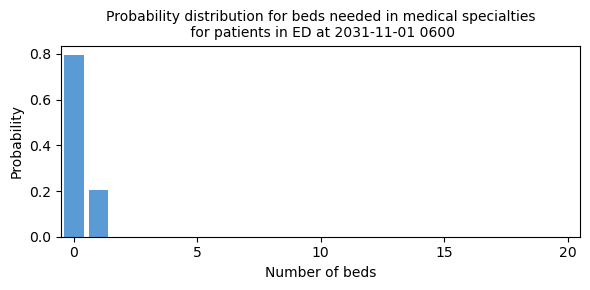

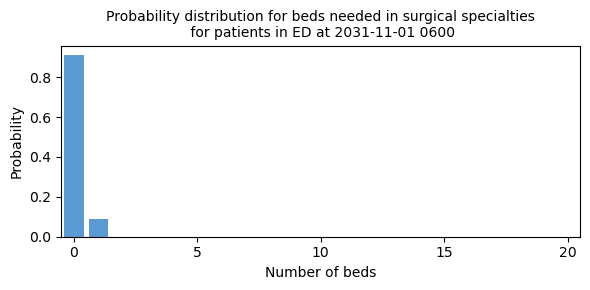

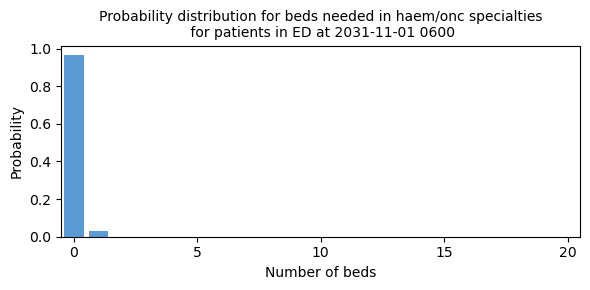

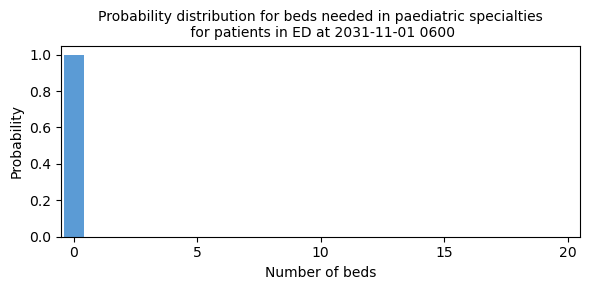

In [172]:
from viz.prob_dist_plot import prob_dist_plot

for spec_ in ['medical', 'surgical', 'haem/onc', 'paediatric']:

    title_ = f'Probability distribution for beds needed in {spec_} specialties\n for patients in ED at 2031-11-01 {MODEL__ED_ADMISSIONS__NAME[-4:]}'
    prob_dist_plot(prob_dist_data=prob_dist_dict_all[MODEL__ED_ADMISSIONS__NAME][spec_][example_dt]['agg_predicted'], title=title_,  include_titles=True)